In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
import os

# https://stackoverflow.com/questions/53308674/audio-frequencies-in-python
def read_wav(wav_file_name):
    sr, signal = wavfile.read(wav_file_name)
    return (sr, signal[:, 0]) # use the first channel (or take their average, alternatively)
    
def fetch_frequencies(wav_file_name):
    sr, y = read_wav(wav_file_name)
    return y

def show_frequency_spectrum(wav_file_name):
    sr, y = read_wav(wav_file_name)
    t = np.arange(len(y)) / float(sr)
    
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, y)
    plt.xlabel('t')
    plt.ylabel('y')

    plt.show()


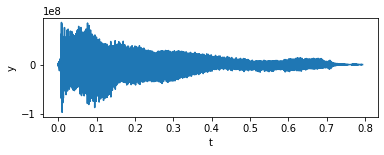

In [12]:
show_frequency_spectrum('samples/C/1/splitted_chord007.wav')

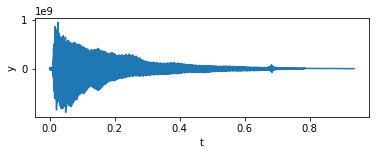

In [11]:
show_frequency_spectrum('samples/A/1/splitted_chord007.wav')

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0
